In [2]:
import cv2 as cv
import numpy as np

# define a custom class to read filename from cv.imread
class MyImage:
    def __init__(self, img_name):
        self.img = cv.imread(img_name, cv.IMREAD_GRAYSCALE)
        self.__name = img_name

    def __str__(self):
        return self.__name

In [3]:
import matplotlib.pyplot as plt


def scale_calibration(img):
    # read img
    scale = cv.imread(img, cv.IMREAD_GRAYSCALE)
    # invert background
    scale = 255 - scale
    # binarize img
    _, scale_bin = cv.threshold(scale, 40, 255, cv.THRESH_BINARY)
    # get bounding rectangle to get width of the scale
    x, y, w, h = cv.boundingRect(scale_bin)
    # define calibration (known distance / distance in pixels of scale)
    calibration = 0.5 / w
    # plot bounding rectangle to debug
    plt.imshow(cv.rectangle(scale, cv.boundingRect(scale_bin), (255, 255, 0), 2))

    return calibration

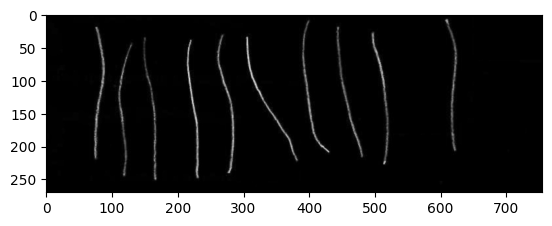

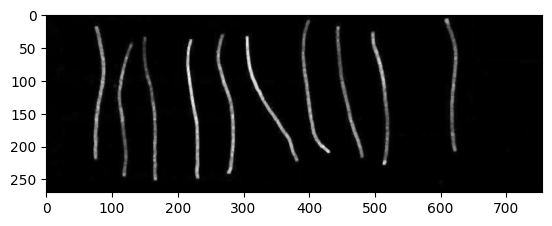

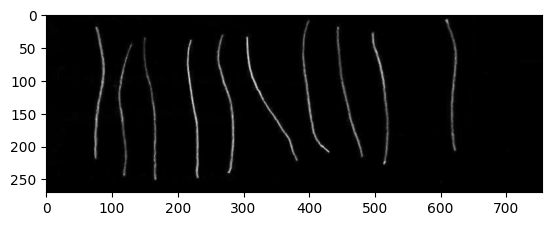

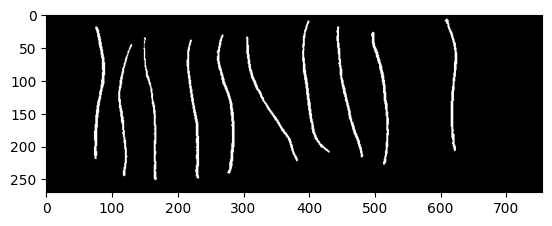

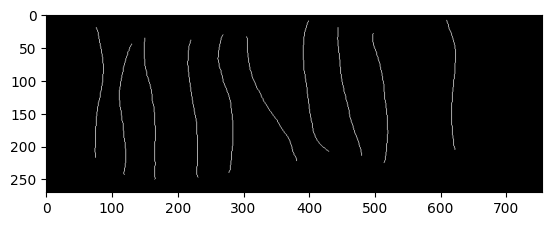

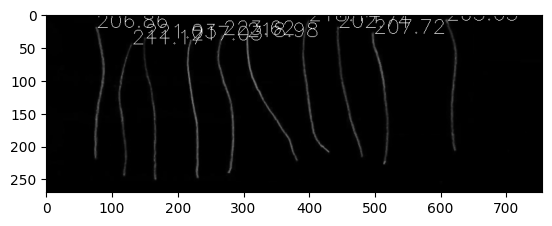

10
['lines_1.jpg', [211.1690467596054, 217.0269113779068, 221.0269113779068, 218.98022854328156, 223.61879414319992, 207.7192993760109, 202.7401144504547, 206.85533845424652, 218.13960945606232, 205.6482316851616]]


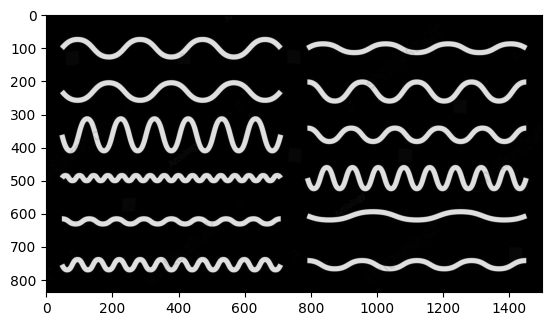

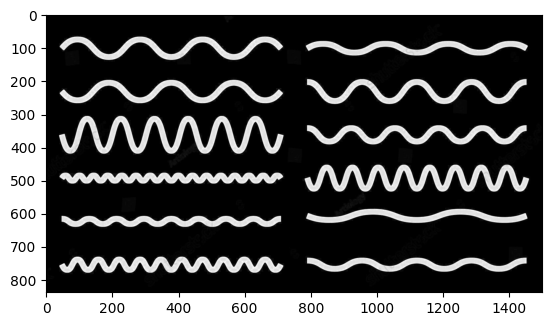

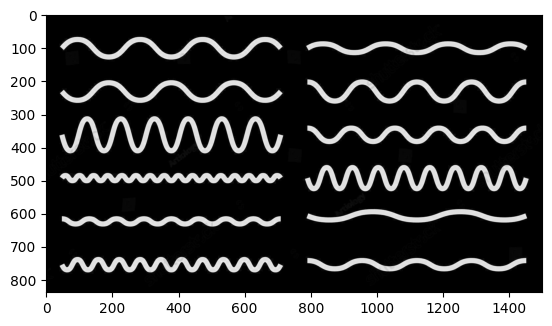

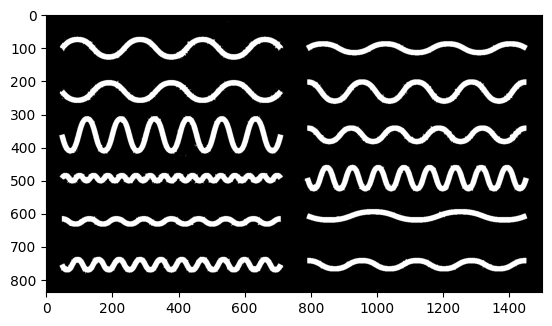

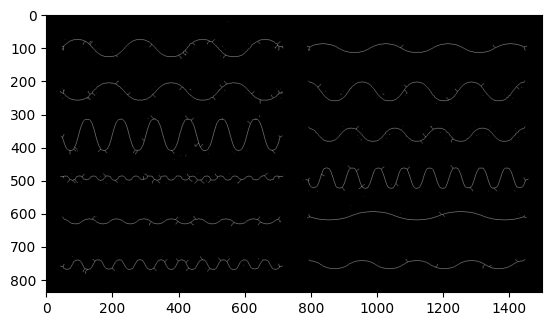

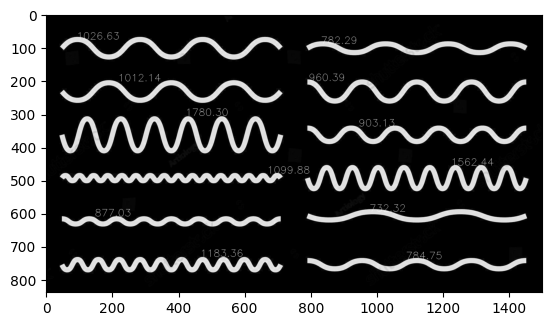

12
['lines_2.jpeg', [784.7482978105545, 1183.3641284108162, 877.0275154709816, 732.318322122097, 1099.8752760887146, 1562.4387650489807, 903.1290674209595, 1780.2976740002632, 1012.1412601470947, 960.3899945616722, 782.2924546599388, 1026.6265394091606]]


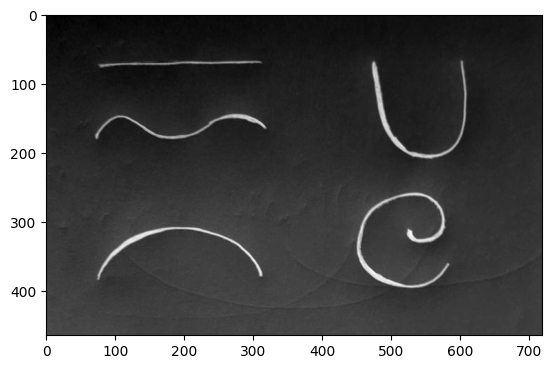

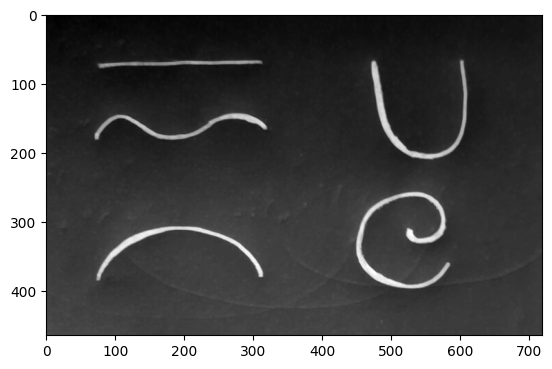

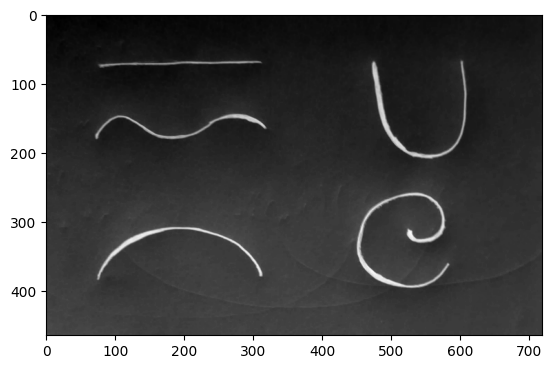

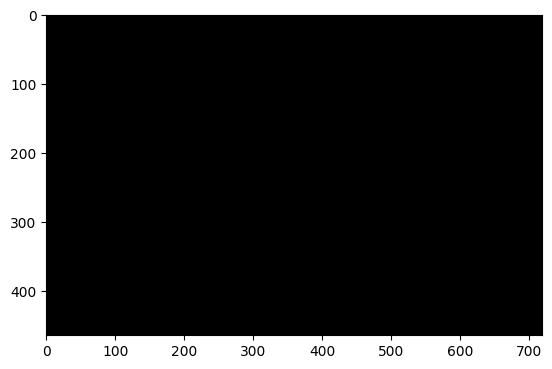

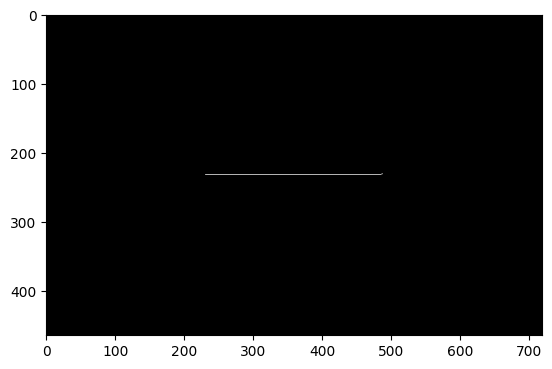

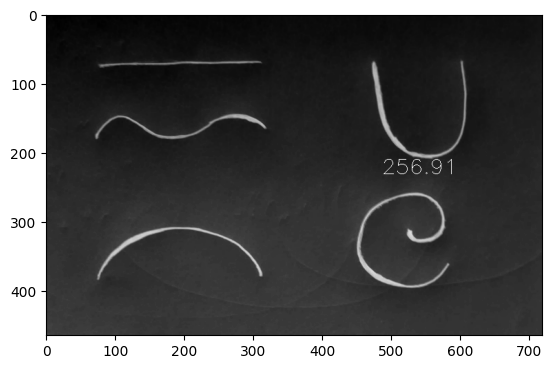

1
['lines_3.jpg', [256.91421353816986]]


In [4]:
from plantcv import plantcv as pcv
from skimage.morphology import skeletonize


def fiberLen(img, calibration, plot=True):

    # read img
    fiber = MyImage(img)

    # store filename
    filename = str(img)

    # invert background to get white pixels on black background
    fiber = 255 - fiber.img


    plt.imshow(fiber, cmap="gray")
    plt.show()

    # dilate then erode to connect disconnected pixels
    fiber = cv.dilate(fiber, None, iterations=1)
    plt.imshow(fiber, cmap="gray")
    plt.show()
    fiber = cv.erode(fiber, None, iterations=1)
    plt.imshow(fiber, cmap="gray")
    plt.show()

    _, fiber_bin = cv.threshold(fiber, 20, 255, cv.THRESH_BINARY)

    # binarize img transforming pixel values to 0s and 1s
    height, width = fiber_bin.shape
    for i in range(height):
        for j in range(width):
            fiber_bin[i][j] = 1 if fiber_bin[i][j] == 255 else 0

    plt.imshow(fiber_bin, cmap="gray")
    plt.show()

    fiber_skel = pcv.morphology.skeletonize(
        fiber_bin
    )  # pcv skeletonize returns 0 and 1 img / skimage skel returns True and False values

    plt.imshow(fiber_skel, cmap="gray")
    plt.show()

    # get contours
    contours, hierarchy = cv.findContours(
        fiber_skel, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE
    )

    # get only contours of fibers (which usually will be greater than 200)
    fiber_contours = [c for c in contours if cv.arcLength(c, False) > 100]

    # initialize lists to store variables
    measurement = []
    label_coord_x = []
    label_coord_y = []

    # get contour perimeter, divide it by 2 and multiply by calibration factor
    for i, cnt in enumerate(fiber_contours):
        measurement.append(
            float(cv.arcLength(fiber_contours[i], False) / 2) * calibration
        )
        # get coordinates if plot is True
        if plot is True:
            label_coord_x.append(
                fiber_contours[i][0][0][0]
            )  # get first pixel of contours
            label_coord_y.append(
                fiber_contours[i][0][0][1]
            )  # get second pixel of contours

    # plot fiber measurements if plot is True
    if plot is True:
        fiber_copy = fiber.copy()
        # loop through measurement values
        for i, value in enumerate(measurement):
            text = "{:.2f}".format(value)
            x = label_coord_x[i]
            y = label_coord_y[i]
            # put measurement labels in image
            cv.putText(
                fiber_copy,
                text=text,
                org=(x, y),
                fontFace=cv.FONT_HERSHEY_SIMPLEX,
                fontScale=1,
                color=(255, 255, 255),
                thickness=1,
            )
        plt.imshow(fiber_copy, cmap="gray")
        plt.show()

    print(len(measurement))

    return [filename, measurement]


print(fiberLen("lines_1.jpg", 1))
print(fiberLen("lines_2.jpeg", 1))
print(fiberLen("lines_3.jpg", 1))